# Data Extraction

In [1]:
import urllib.request as urllib2
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import csv

In [2]:
today = datetime.date.today()
mktcap_page = 'https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&amp;end='+"{:%Y%m%d}".format(today)
page = urllib2.urlopen(mktcap_page)
soup = BeautifulSoup(page, 'html.parser')
table = soup.find("table")

In [3]:
headings = [th.get_text().strip() for th in table.find("tr").find_all("th")]
headings = [x.replace('*','') for x in headings]
headings

['Date', 'Open*', 'High', 'Low', 'Close**', 'Volume', 'Market Cap']

In [5]:
datasets = []

for row in soup.find_all("tr")[1:]:
    dataset = dict(zip(headings, (tr.get_text() for tr in row.find_all("td"))))
    if len(dataset) > 1:
        datasets.append(dataset)

datasets[0]

{'Close': '309.64',
 'Date': 'Jul 26, 2020',
 'High': '316.39',
 'Low': '300.27',
 'Market Cap': '34,656,472,193',
 'Open': '303.69',
 'Volume': '12,003,973,026'}

In [6]:
my_df = pd.DataFrame(datasets)
full_data = my_df.set_index('Date')
#full_data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']]
full_data.to_csv('full_data_eth_25072020.csv', index=True, header=True)
full_data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
"Jul 26, 2020",303.69,316.39,300.27,309.64,"12,003,973,026","34,656,472,193"
"Jul 25, 2020",279.03,306.74,279.03,304.06,"10,785,021,813","34,027,002,730"
"Jul 24, 2020",274.72,286.19,269.24,279.22,"9,466,060,358","31,243,266,716"
"Jul 23, 2020",262.39,277.58,261.05,274.69,"10,281,309,262","30,733,019,165"
"Jul 22, 2020",245.04,262.99,242.48,262.19,"7,702,077,383","29,331,058,164"


In [7]:
full_data.shape

(1816, 6)

In [8]:
full_data.dtypes

Open          object
High          object
Low           object
Close         object
Volume        object
Market Cap    object
dtype: object

In [9]:
def obj_to_int(x):
    x = x.replace(',','')
    return float(x)
full_data['Low'] = full_data['Low'].apply(obj_to_int)
full_data['High'] = full_data['High'].apply(obj_to_int)
full_data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
"Jul 26, 2020",303.69,316.39,300.27,309.64,"12,003,973,026","34,656,472,193"
"Jul 25, 2020",279.03,306.74,279.03,304.06,"10,785,021,813","34,027,002,730"
"Jul 24, 2020",274.72,286.19,269.24,279.22,"9,466,060,358","31,243,266,716"
"Jul 23, 2020",262.39,277.58,261.05,274.69,"10,281,309,262","30,733,019,165"
"Jul 22, 2020",245.04,262.99,242.48,262.19,"7,702,077,383","29,331,058,164"


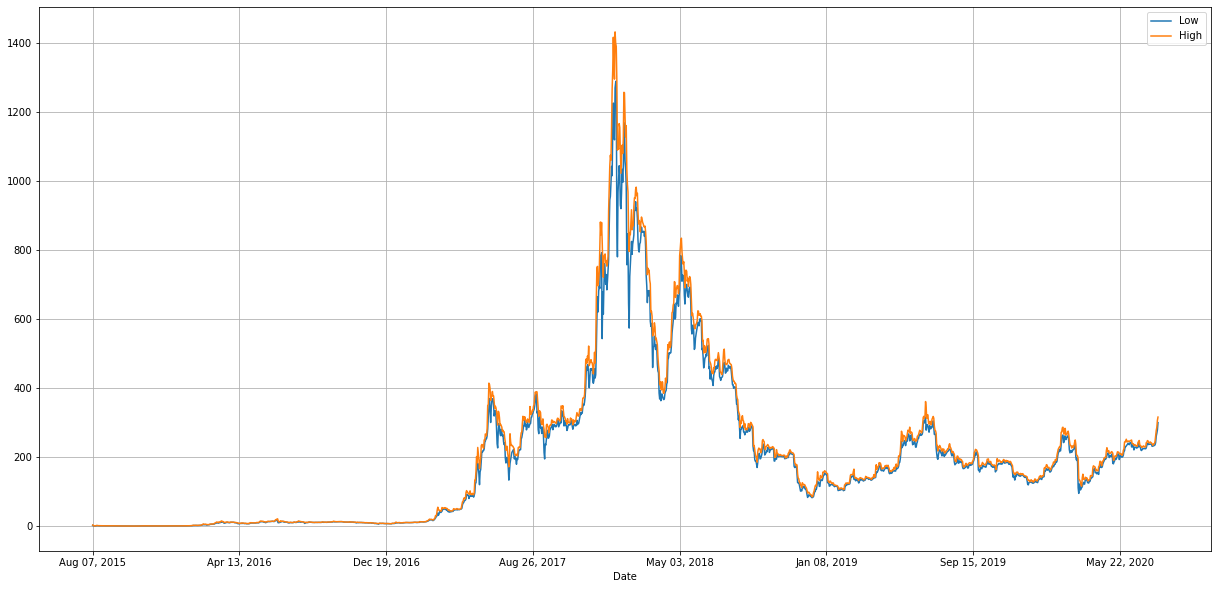

In [10]:
_= full_data[['Low','High']][::-1].plot(grid=True, figsize=(21, 10))

# Preparing data for time series

In [11]:
# This function replaces ',' for nothing and then changes data type object to float

def obj_to_num(df,cols):
    
    def obj_to_num(row):
        if ',' in str(row):
          row = row.replace(',','')
          return float(row)
        else:
          return float(row)

    for col in cols:     
        df[col] = df[col].apply(obj_to_num) 
    return df

# This function changes data column (object) to timestamp[ns] and also can change all dataframe clumns to float 

def prepare_data(file):

  dateparse = lambda x: pd.datetime.strptime(x, '%b %d, %Y').strftime('%Y-%m-%d')
  data  = pd.read_csv(file, parse_dates=[0], date_parser=dateparse)
  columns = ['Open','High','Low','Close','Volume','Market Cap']
  num_data = obj_to_num(data,columns)
  data['Date'] = data['Date'].dt.tz_localize(None)
  data = data.groupby([pd.Grouper(key='Date', freq='H')]).first().reset_index()
  data = data.set_index('Date')
  data = data[['High','Low']]
  data.dropna(subset=['High','Low'], inplace=True)

  return data

In [12]:
file = 'full_data_eth_25072020.csv'
data = prepare_data(file)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


,High,Low
Date,,
2015-08-07,3.540000,2.520000
2015-08-08,2.800000,0.714725
2015-08-09,0.879810,0.629191
2015-08-10,0.729854,0.636546
2015-08-11,1.130000,0.663235


In [13]:
data.index

DatetimeIndex(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10',
               '2015-08-11', '2015-08-12', '2015-08-13', '2015-08-14',
               '2015-08-15', '2015-08-16',
               ...
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26'],
              dtype='datetime64[ns]', name='Date', length=1816, freq=None)

In [14]:
!pip install chart_studio

     |████████████████████████████████| 71kB 1.8MB/s 


In [15]:
import plotly.graph_objects as go
import chart_studio as py

import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [16]:
py.tools.set_credentials_file(username='xxxx', api_key='xxxxxx')

In [17]:
trace1 = go.Scatter(
    x = data.index,
    y = data['High'].astype(float),
    mode = 'lines',
    name = 'swipe Price (High)'
)
trace2 = go.Scatter(
    x = data.index,
    y = data['Low'].astype(float),
    mode = 'lines',
    name = 'swipe Price (High)'
)

layout = dict(
    title='Historical swipe High price (USD) (...-2020)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2]
fig = dict(data = data.copy(), layout=layout)
py.plotly.iplot(fig, filename = "Time Series with Rangeslider")

# Sarimax Model

## To trade dayli we want to know low and high prices on x number of days the closer the predictions are the more accurate result we have

In [18]:
!pip install pyramid-arima
from pyramid.arima import auto_arima

     |████████████████████████████████| 604kB 3.5MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning:


    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https:/

In [24]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
import matplotlib.pyplot as plt

In [19]:
# We do this again because the fo@#!ing pyplot plot changed data types 
file = 'full_data_eth_25072020.csv'
data = prepare_data(file)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



In [20]:
data.head()

,High,Low
Date,,
2015-08-07,3.540000,2.520000
2015-08-08,2.800000,0.714725
2015-08-09,0.879810,0.629191
2015-08-10,0.729854,0.636546
2015-08-11,1.130000,0.663235


In [21]:
data_high = pd.DataFrame(data['High'].copy())
data_high.head()

,High
Date,
2015-08-07,3.540000
2015-08-08,2.800000
2015-08-09,0.879810
2015-08-10,0.729854
2015-08-11,1.130000


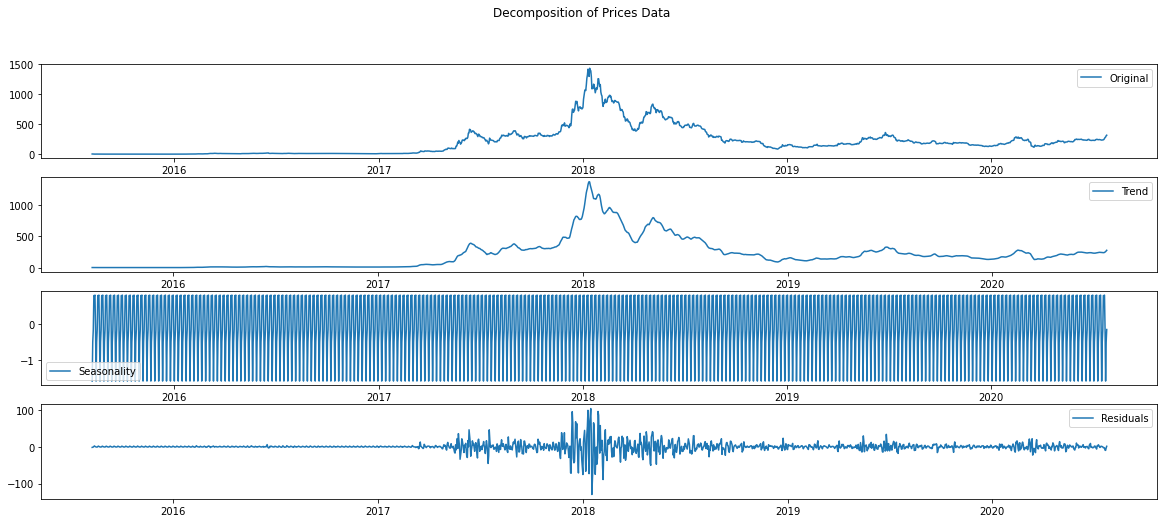

In [25]:
decomposition = sm.tsa.seasonal_decompose(data.High)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(data.High, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

In [26]:
# Test for p-value and null hypotesis
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.High)[1])

Dickey–Fuller test: p=0.105081


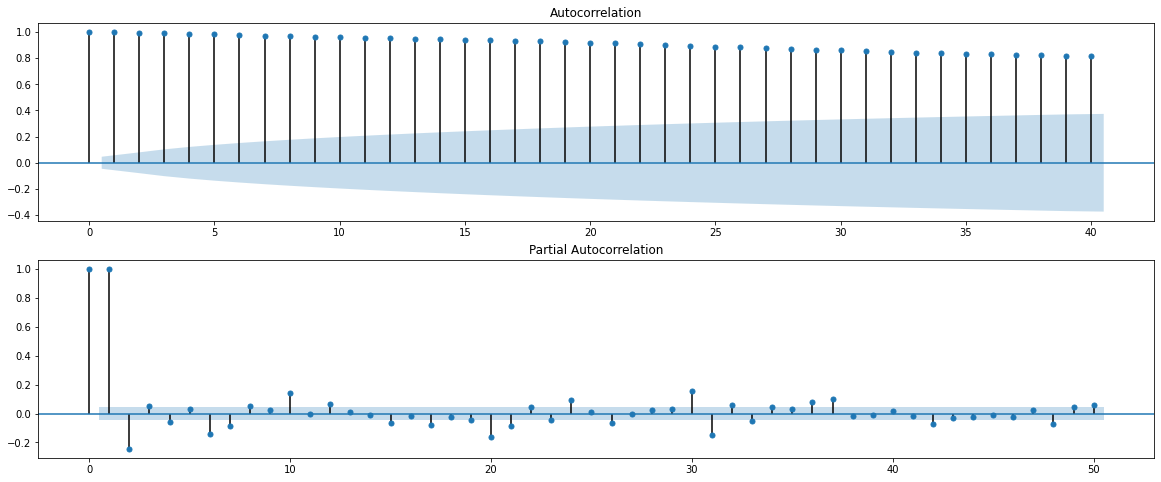

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(20,8))
pyplot.subplot(211)
plot_acf(data.High, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(data.High, ax=pyplot.gca(), lags=50)
pyplot.show()

In [28]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.High, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Dickey–Fuller test:: p=0.000000


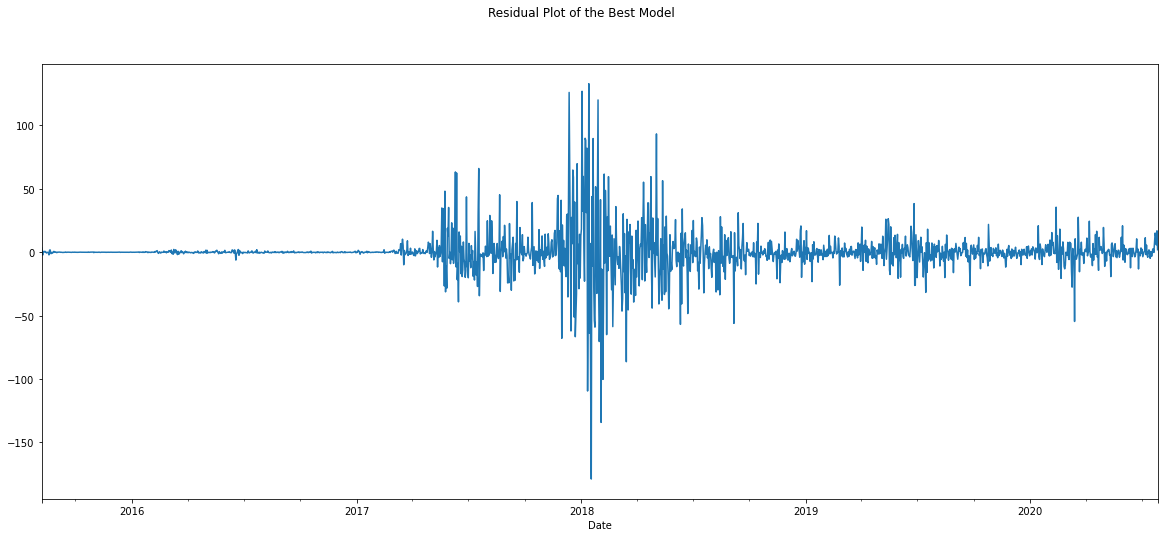

In [29]:
fig = plt.figure(figsize=(20,8))
best_model.resid.plot()
fig.suptitle('Residual Plot of the Best Model')
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

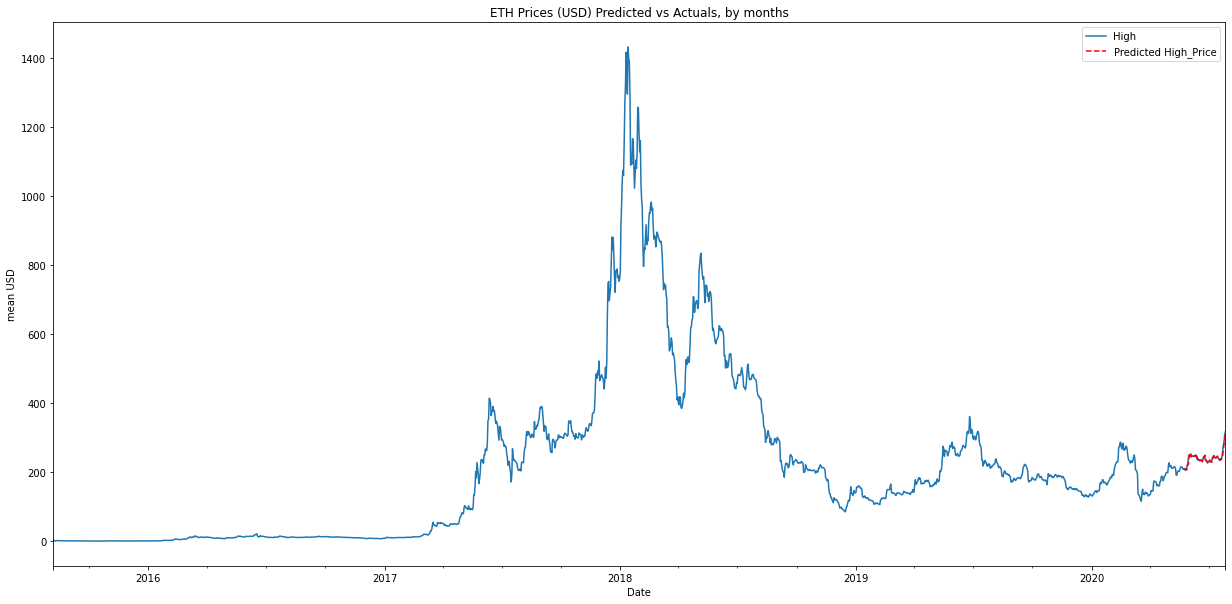

In [36]:
df_month2 = data[['High']]
future = pd.DataFrame()
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=1750, end=1816)
plt.figure(figsize=(21,10))
df_month2.High.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted High_Price')
plt.legend()
plt.title('ETH Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('mean USD')
plt.show()

In [38]:
df_month2['forecast'] = best_model.predict(start=1795, end=1816)
df_month2[-20:]

,High,forecast
Date,,
2020-07-07,242.68,244.494909
2020-07-08,248.31,242.655606
2020-07-09,247.29,249.429216
2020-07-10,242.88,246.833932
2020-07-11,241.53,241.139420
2020-07-12,243.31,241.402075
2020-07-13,244.31,244.999028
2020-07-14,242.00,246.814057
2020-07-15,241.40,240.830027


In [41]:
# 1795 = 2020-07-06 and 1816 = 2020-07-26 so lets see what would be the price in the next 6 days
best_model.predict(start=1815, end=1821)

2020-07-26    314.405085
2020-07-27    317.654981
2020-07-28    320.238176
2020-07-29    320.606727
2020-07-30    322.398751
2020-07-31    322.579118
2020-08-01    323.490502
Freq: D, dtype: float64